## Create Spark Session
This sets up the PySpark environment for local processing.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AppleHealthAnalysis") \
    .getOrCreate()


25/05/12 19:55:05 WARN Utils: Your hostname, rozhins-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.209 instead (on interface en0)
25/05/12 19:55:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/12 19:55:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Read the transformed data to show only the first 5 row for verification

In [2]:
df = spark.read.csv("../data/export.csv", header=True, inferSchema=True)
df.show(5)


+--------------------+-----+-------------------+-------------------+
|                type|value|          startDate|            endDate|
+--------------------+-----+-------------------+-------------------+
|HKQuantityTypeIde...|572.0|2024-04-09 17:26:04|2024-04-09 17:35:21|
|HKQuantityTypeIde...| 55.0|2024-04-09 18:08:14|2024-04-09 18:16:53|
|HKQuantityTypeIde...| 16.0|2024-03-25 06:20:53|2024-03-25 06:24:46|
|HKQuantityTypeIde...|  8.0|2024-03-25 07:33:47|2024-03-25 07:33:50|
|HKQuantityTypeIde...| 12.0|2024-03-25 11:11:07|2024-03-25 11:11:12|
+--------------------+-----+-------------------+-------------------+
only showing top 5 rows



Filter by only steps counts, sleep details and the burnt calories

In [3]:
focus_types = [
    "HKQuantityTypeIdentifierStepCount",
    "HKQuantityTypeIdentifierActiveEnergyBurned",
    "HKCategoryTypeIdentifierSleepAnalysis"
]

df_filtered = df.filter(df["type"].isin(focus_types))
df_filtered.show(5)


+--------------------+-----+-------------------+-------------------+
|                type|value|          startDate|            endDate|
+--------------------+-----+-------------------+-------------------+
|HKQuantityTypeIde...|572.0|2024-04-09 17:26:04|2024-04-09 17:35:21|
|HKQuantityTypeIde...| 55.0|2024-04-09 18:08:14|2024-04-09 18:16:53|
|HKQuantityTypeIde...| 16.0|2024-03-25 06:20:53|2024-03-25 06:24:46|
|HKQuantityTypeIde...|  8.0|2024-03-25 07:33:47|2024-03-25 07:33:50|
|HKQuantityTypeIde...| 12.0|2024-03-25 11:11:07|2024-03-25 11:11:12|
+--------------------+-----+-------------------+-------------------+
only showing top 5 rows



Filter by 30 days

In [4]:
from pyspark.sql.functions import to_date, col
from datetime import datetime, timedelta

# Add date column
df_with_date = df_filtered.withColumn("date", to_date("startDate"))

# Filter for last 30 days
today = datetime.now()
thirty_days_ago = today - timedelta(days=30)

df_30days = df_with_date.filter(
    col("date") >= thirty_days_ago.strftime("%Y-%m-%d")
)


Then I group and convert:

convert to Pandas to plot to Pandas

In [5]:
from pyspark.sql.functions import sum as _sum

df_summary = df_30days.groupBy("type", "date").agg(
    _sum("value").alias("total_value")
)
summary_pd = df_summary.toPandas()


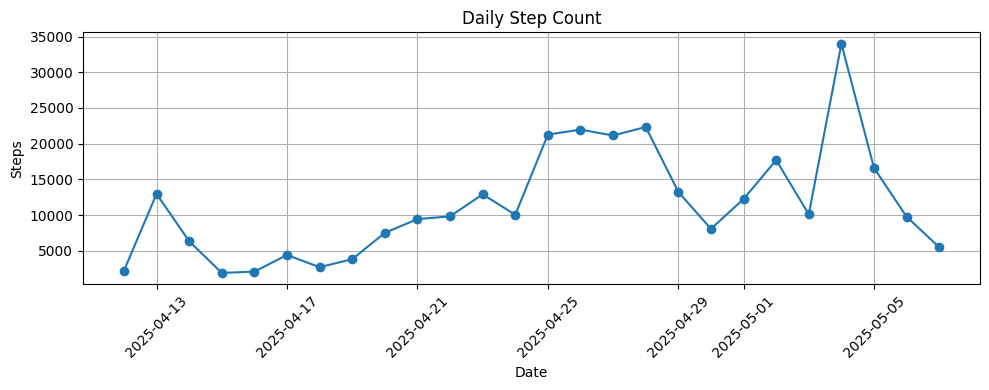

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot Step Count
steps = summary_pd[summary_pd['type'] == "HKQuantityTypeIdentifierStepCount"]
# Ensure one value per date
steps = steps.groupby("date")["total_value"].sum().reset_index()

plt.figure(figsize=(10,4))
plt.plot(steps["date"], steps["total_value"], marker='o')
plt.title("Daily Step Count")
plt.xlabel("Date")
plt.ylabel("Steps")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../notebooks/step_trend.png")
plt.show()

plot Sleep

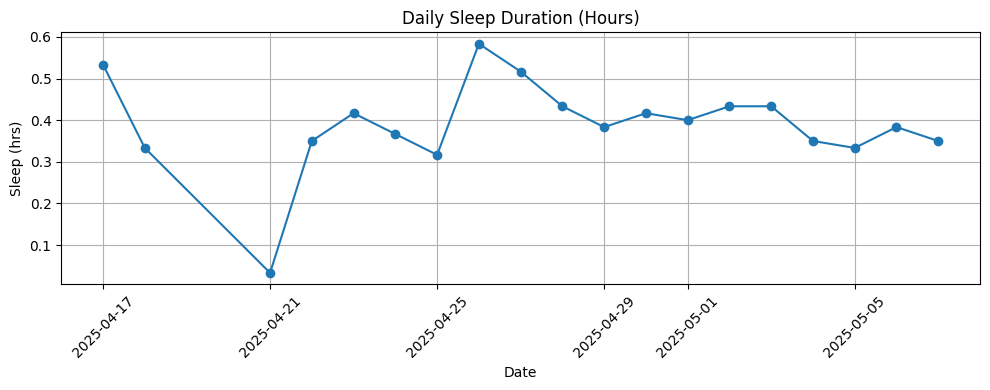

<Figure size 640x480 with 0 Axes>

In [ ]:
sleep = summary_pd[summary_pd['type'] == "HKCategoryTypeIdentifierSleepAnalysis"]
sleep = sleep.groupby("date")["total_value"].sum().reset_index()
plt.figure(figsize=(10,4))
plt.plot(sleep["date"], sleep["total_value"] / 60, marker='o')  # convert minutes to hours
plt.title("Daily Sleep Duration (Hours)")
plt.xlabel("Date")
plt.ylabel("Sleep (hrs)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../notebooks/sleep_trend.png")
plt.show()


Calories / Active Energy

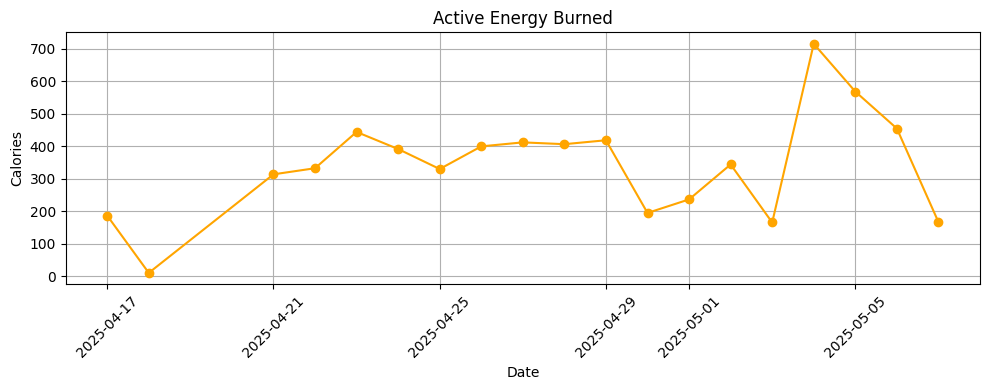

<Figure size 640x480 with 0 Axes>

In [ ]:
energy = summary_pd[summary_pd['type'] == "HKQuantityTypeIdentifierActiveEnergyBurned"]
energy = energy.groupby("date")["total_value"].sum().reset_index()
plt.figure(figsize=(10,4))
plt.plot(energy["date"], energy["total_value"], marker='o', color='orange')
plt.title("Active Energy Burned")
plt.xlabel("Date")
plt.ylabel("Calories")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../notebooks/energy_trend.png")
plt.show()
